# Расчет близости текстов

# Библиотеки

In [1]:
import json
import os
#from google.colab import drive
from tqdm import tqdm
import pickle
from collections import Counter
import time

import pandas as pd

import numpy as np
import scipy
from scipy import spatial

import torch
from sentence_transformers import SentenceTransformer, util

import matplotlib.pyplot as plt
import seaborn as sns

# Предобученная модель

In [2]:
#model = SentenceTransformer('bert-base-nli-mean-tokens') #эта быстрее
model = SentenceTransformer('bert-large-nli-mean-tokens') #эта точнее

# Датасет с embedding

Загружаем таблицу с уже посчитанными ембедингами и кластерами для двух подвыборок из редита

In [3]:
%%time
comments_dir = r"\Users\Home\Documents\Data Science\comptech\weights"

comments_df = pd.DataFrame()
tmp = pd.DataFrame()

for my_file in tqdm(os.listdir(comments_dir), position=0, leave=True):
    print(my_file)
    with open(os.path.join(comments_dir, my_file), mode='rb') as pandas_file:
        tmp = pickle.load(pandas_file)
        comments_df = comments_df.append(tmp)
del(tmp)

100%|██████████| 1/1 [00:00<00:00, 10.28it/s]

comments_df.pickle
Wall time: 102 ms


In [4]:
trump_df = comments_df[comments_df['part'] == 'trump'][['body', 'part', 'embedding','label']]
biden_df = comments_df[comments_df['part'] == 'biden'][['body', 'part', 'embedding','label']]

# Создаем искуственную подвыборку c лозунгами за Трампа

In [5]:
trump_ref_texts = (
'This is why we need Trump to win. With the USA as  trendsetter, we can purge the traitors from office!',
'Bitcoin will soon be called Trump Coin it’ll be so great!',
'Daddy Trump is gonna make Daycare Great Again!',
'they was hoping trump would give them a boost in california. the tears are delicious',
'Flawless Centipede... Submit to @Twinksfortrump and follow @Gay4Trump',
'But if Bernie debates trump and a meteorite hit Hillary then sanders will win! Remember guys phone bank, donate, match me',
'edited because i was a tool, and edited to say LostTrumpSupporter is AWESOME!',
'my best tips are almost always from trump supporters. i guess when youre employed you can afford to be a generous person',
'And it will work, until Trump makes America so fucking awesome nobody would want to change it.',
'Poseidon is doing his best to protect the West.  Thank you based Poseidon.',
'Trump/Poseidon 2016',
'Probably made a script to respond to all of Trump’s newest tweets with pre-written tweets. He’s an impressive centipede!',
'Donald Trump is best',
'Trump has a diet for this country and trust me it’s gonna be nutritious and delicious',
'Mr. Trump all we do is win i need a break!',
'Babes are awesome so are Trump fellas.',
'That’s a cuck way of looking at it, Trump WILL WIN 50+DC!',
'Trump Tower has the best taco bowls.',
"immigrants are bad",
"Immigrants will take American jobs, lower our wages, and especially hurt the poor",
"Immigrants abuse the welfare state",
"Immigrants increase the budget deficit and government debt",
"Immigrants increase economic inequality",
"Today’s immigrants don’t assimilate like immigrants from previous waves did",
"Immigrants are a major source of crime",
"Immigrants pose a unique risk today because of terrorism",
"It’s easy to immigrate to America and we’re the most open country in the world",
"Amnesty or a failure to enforce our immigration laws will destroy the Rule of Law in the United States",
"By not exercising control over borders through actively blocking immigrants, the users of this argument warn, the United States government will surrender a vital component of its national sovereignty",
"Immigrants won’t vote for the Republican Party",
"Immigrants bring with them their bad cultures, ideas, or other factors that will undermine and destroy our economic and political institutions.  The resultant weakening in economic growth means that immigrants will destroy more wealth than they will create over the long run",
"The brain drain of smart immigrants to the United State impoverished other countries",
"Immigrants will increase crowding, harm the environment",
'Hey man im in north jersey as well. I wear my MAGA gear with pride and drive around with my trump bumper sticker. Im in morris county. Dont let the libs win. Trump 2016!!!',
'I’m not asking for a VP that is lockstep with Trump. But accepting a VP who was a prime mover in the passage of one of the greatest frauds foisted upon the US ever is NOT acceptable as VP. VP is a heartbeat from POTUS',
'The official Donald Trump MAGA cap is the one the Don himself wears. It’s the one I bought, and let me tell you folks, it is the best hat around, the best, believe me.'
)

trump_vec = model.encode(trump_ref_texts, show_progress_bar=True, convert_to_numpy=True, device='cuda')

ref_df = pd.DataFrame({'body': trump_ref_texts, 'embedding':list(trump_vec)})

# Сраваниваем наше предложение с тремя подвыборками

In [15]:
#Compute embeddings for the sentence we want to compare
query = 'Trump is the best!'
query_vec = model.encode(query, show_progress_bar=True, convert_to_numpy=True, device='cuda')

In [16]:
%%time
trump_scores = list()
for vec in list(trump_df['embedding']):
    trump_scores.append(1 - spatial.distance.cosine(vec, query_vec))
trump_df['similarity'] = trump_scores

biden_scores = list()
for vec in list(biden_df['embedding']):
    biden_scores.append(1 - spatial.distance.cosine(vec, query_vec))
biden_df['similarity'] = biden_scores

ref_scores = list()
for vec in list(ref_df['embedding']):
    ref_scores.append(1 - spatial.distance.cosine(vec, query_vec))
ref_df['similarity'] = ref_scores

Wall time: 814 ms


In [17]:
print(trump_df['similarity'].mean())
print(biden_df['similarity'].mean())
print(ref_df['similarity'].mean())

0.3580387309089609
0.379574904473943
0.4855378688209587


Посмотрим на распределение расстояния

<AxesSubplot:>

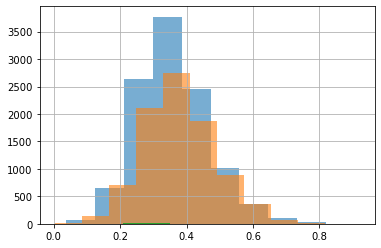

In [18]:
trump_df['similarity'].hist(alpha=0.6)
biden_df['similarity'].hist(alpha=0.6)
ref_df['similarity'].hist()